# Benchmarking Aura features

In [27]:
import os
import timeit

import numpy as np
import seaborn as sns
from tqdm import tqdm
from dotenv import load_dotenv

from graphdatascience import GdsSessions
from graphdatascience.session import DbmsConnectionInfo, AuraAPICredentials, SessionMemory

In [28]:
load_dotenv("credentials.env")

CLIENT_ID = os.environ.get("CLIENT_ID")
CLIENT_SECRET = os.environ.get("CLIENT_SECRET")

DB_PASSWORD = os.environ.get("DB_PASSWORD")
DB_ID = os.environ.get("DB_ID")

db_connection_info = DbmsConnectionInfo(
    f"neo4j+s://{DB_ID}-{os.environ['AURA_ENV']}.databases.neo4j-dev.io", "neo4j", DB_PASSWORD
)

In [30]:
sessions = GdsSessions(AuraAPICredentials(CLIENT_ID, CLIENT_SECRET))
session_name = "benchmark-session3"
session_pw = "my-password"

print("Starting GDS session")
gds = sessions.get_or_create(session_name, SessionMemory.m_24GB, db_connection=db_connection_info)

Starting GDS session


In [32]:
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation


In [5]:
def measure(func, setup, iterations, warmup_iterations):
    pbar = tqdm(total=iterations + warmup_iterations)

    def wrapper():
        value = func()
        pbar.update(1)
        return value

    pbar.set_description("Warmup")
    warmup = timeit.repeat(wrapper, setup=setup, number=1, repeat=warmup_iterations)

    pbar.set_description("Measurement")
    measurement = timeit.repeat(wrapper, setup=setup, number=1, repeat=iterations)

    pbar.close()

    return {"iterations": measurement, "mean": np.mean(measurement), "avg": np.average(measurement)}

## Projection

In [73]:
def run_remote_projection(query, concurrency):
    with gds.graph.project("graph", query, concurrency=concurrency) as G:
        print(G)

In [8]:
run_remote_projection(
    """
    CYPHER runtime=parallel
    MATCH (u)
    OPTIONAL MATCH (u)-[r]->(t)
    RETURN gds.graph.project.remote(u, t, {})
    """,
    concurrency=1,
)

Graph(name=graph, node_count=0, relationship_count=0)


In [61]:
G, result = gds.graph.project(
    "large",
    """
    CYPHER runtime=parallel
    MATCH (u)
    OPTIONAL MATCH (u)-[r]->(t)
    RETURN gds.graph.project.remote(u, t, {})
    """,
    batch_size=100000,
)

print(G)
print(result)

Graph(name=large, node_count=29987836, relationship_count=176623445)
nodeCount             29987836
relationshipCount    176623445
Name: 0, dtype: int64


### Project entire graph, structure only

#### No parallel Runtime

In [39]:
data = {}
for concurrency in [8]:
    result = measure(
        lambda: run_remote_projection(
            """
            MATCH (u)
            OPTIONAL MATCH (u)-[r]->(t)
            RETURN gds.graph.project.remote(u, t, null)
            """,
            concurrency=concurrency,
        ),
        lambda: gds.graph.drop("graph", failIfMissing=False),
        iterations=1,
        warmup_iterations=1,
    )
    data[concurrency] = result

Measurement:  50%|█████     | 1/2 [03:04<03:04, 184.25s/it]

Graph(name=graph, node_count=29987836, relationship_count=176623445)


Measurement: 100%|██████████| 2/2 [05:45<00:00, 172.77s/it]

Graph(name=graph, node_count=29987836, relationship_count=176623445)


[Text(0.5, 0, 'concurrency'), Text(0, 0.5, 'average runtime')]

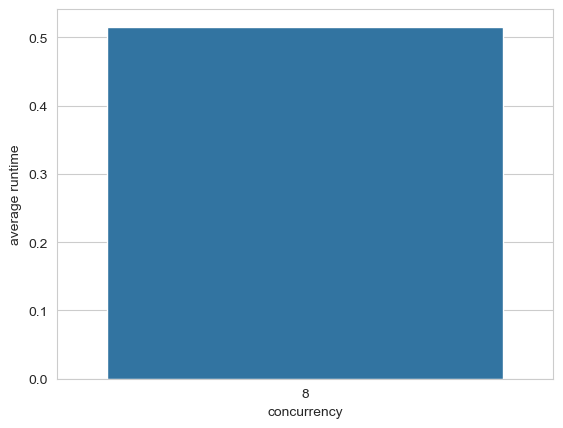

In [10]:
values = {k: v["mean"] for k, v in list(data.items())}

plot = sns.barplot(values)
plot.set(xlabel="concurrency", ylabel="average runtime")

#### Parallel Runtime







  0%|          | 0/3 [00:00<?, ?it/s]





Warmup:   0%|          | 0/3 [00:00<?, ?it/s]





Warmup:  33%|███▎      | 1/3 [01:34<03:08, 94.19s/it]





Measurement:  33%|███▎      | 1/3 [01:34<03:08, 94.19s/it]

Graph(name=graph, node_count=29987836, relationship_count=176623445)








Measurement:  67%|██████▋   | 2/3 [03:01<01:30, 90.30s/it]

Graph(name=graph, node_count=29987836, relationship_count=176623445)








Measurement: 100%|██████████| 3/3 [04:27<00:00, 89.21s/it]

Graph(name=graph, node_count=29987836, relationship_count=176623445)


[Text(0.5, 0, 'concurrency'), Text(0, 0.5, 'average runtime')]

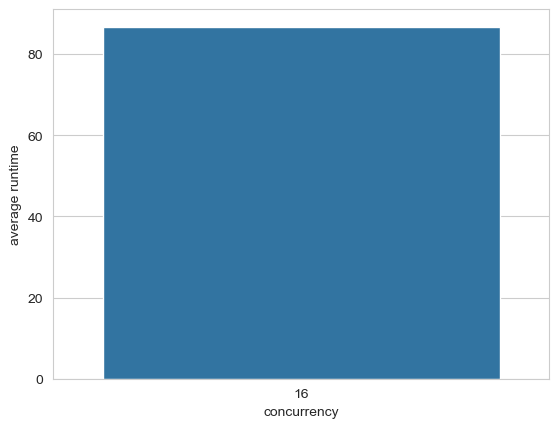

In [90]:
data = {}
for concurrency in [16]:
    result = measure(
        lambda: run_remote_projection(
            """
            CYPHER runtime = parallel
            MATCH (u)
            OPTIONAL MATCH (u)-[r]->(t)
            RETURN gds.graph.project.remote(u, t, null)
            """,
            concurrency=concurrency,
        ),
        lambda: (),
        iterations=2,
        warmup_iterations=1,
    )
    data[concurrency] = result

plot = sns.barplot({k: v["mean"] for k, v in data.items()})
plot.set(xlabel="concurrency", ylabel="average runtime")

### Project entire graph, with properties and labels

In [47]:
query = """
            MATCH (u)
            OPTIONAL MATCH (u)-[r]->(t)
            RETURN gds.graph.project.remote(u, t, {
                sourceNodeLabels: labels(u),
                sourceNodeProperties: {id: id(u)},
                targetNodeLabels: labels(t),
                targetNodeProperties: {id: id(t)},
                relationshipType: type(r),
                relationshipProperties: {id: id(r)}
            })
        """

data = {}
for concurrency in [8]:
    result = measure(
        lambda: run_remote_projection(query, concurrency=concurrency), lambda: (), iterations=2, warmup_iterations=1
    )
    data[concurrency] = result

plot = sns.barplot({k: v["mean"] for k, v in data.items()})
plot.set(xlabel="concurrency", ylabel="average runtime")


Warmup:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Write back

In [62]:
G, _ = gds.graph.project(
    "graph",
    """
    MATCH (u)
    OPTIONAL MATCH (u)-[r]->(t)
    WITH u, t
      WHERE rand() > 0.25
    RETURN gds.graph.project.remote(u, t, {})
    """,
)

In [62]:
G = gds.graph.get("large")

### Node properties

In [55]:
gds.degree.mutate(G, mutateProperty="degree123")

nodePropertiesWritten                                                461670
mutateMillis                                                              0
centralityDistribution    {'min': 0.0, 'max': 5584.0312423706055, 'p90':...
postProcessingMillis                                                      0
preProcessingMillis                                                       0
computeMillis                                                             1
configuration             {'orientation': 'NATURAL', 'mutateProperty': '...
Name: 0, dtype: object

In [63]:
gds.degree.write(
    G, writeProperty="deg23may1424", writeConfiguration={"writeMode": "NATIVE"}, arrowConfiguration={"batchSize": 10000}
)

nodePropertiesWritten                                              29987836
writeMillis                                                         865.053
centralityDistribution    {'min': 0.0, 'max': 9514.062492370605, 'p90': ...
postProcessingMillis                                                    228
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'writeProperty': 'deg23may1424', 'orientation...
Name: 0, dtype: object

In [60]:
gds.graph.nodeProperties.write(G, ["degree123"])

writeMillis               71.975
graphName                 small5
nodeProperties       [degree123]
propertiesWritten         461670
Name: 0, dtype: object

In [66]:
result = measure(
    lambda: gds.graph.nodeProperties.write(G, node_properties=["degree"]),
    lambda: gds.run_cypher("MATCH (n) CALL { WITH n REMOVE n.degree} IN TRANSACTIONS OF 2000 ROWS"),
    iterations=1,
    warmup_iterations=1,
)

print(f"scalar property write-back: {result}")





  0%|          | 0/2 [00:00<?, ?it/s]



Warmup:   0%|          | 0/2 [00:00<?, ?it/s]



Warmup:  50%|█████     | 1/2 [14:01<14:01, 841.83s/it]



Measurement:  50%|█████     | 1/2 [14:01<14:01, 841.83s/it]Failed to read from defunct connection IPv4Address(('p-0aa6c1a2-ba15-4.devpushbased-orch-0001.neo4j-dev.io', 7687)) (ResolvedIPv4Address(('34.38.119.47', 7687)))


SessionExpired: Failed to read from defunct connection IPv4Address(('p-0aa6c1a2-ba15-4.devpushbased-orch-0001.neo4j-dev.io', 7687)) (ResolvedIPv4Address(('34.38.119.47', 7687)))

In [16]:
gds.fastRP.mutate(G, mutateProperty="embedding", embeddingDimension=10, iterationWeights=[1.0])

nodePropertiesWritten                                                    2
mutateMillis                                                             0
nodeCount                                                                2
preProcessingMillis                                                      0
computeMillis                                                           14
configuration            {'mutateProperty': 'embedding', 'jobId': 'fbb9...
Name: 0, dtype: object

In [17]:
result = measure(
    func=lambda: gds.graph.nodeProperties.write(G, node_properties=["embedding"]),
    setup=lambda: gds.run_cypher("MATCH (n) CALL { WITH n REMOVE n.embedding} IN TRANSACTIONS  OF 2000 ROWS"),
    iterations=1,
    warmup_iterations=1,
)

print(f"list property write-back: {result}")

Measurement: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

scalar property write-back: {'iterations': [0.323704333999558], 'mean': 0.323704333999558, 'avg': 0.323704333999558}


### Relationship

In [ ]:
matched_nodes = gds.run_cypher(
    "MATCH (n)-[r]->() WITH count(r) as degree, n WHERE degree > 5 RETURN id(n) ORDER BY id(n) DESC LIMIT 2"
).squeeze()

In [ ]:
gds.allShortestPaths.delta.mutate(G, sourceNode=matched_nodes[0], mutateRelationshipType="MUTATED_RELS", concurrency=6)

In [ ]:
gds.graph.relationship.write(G, relationship_type="MUTATED_RELS", relationship_property="totalCost")

In [ ]:
# cleanup rels

writted_rels_count = gds.run_cypher("MATCH ()-[r:MUTATED_RELS]->() RETURN count(r)")
print(f"written rels: {writted_rels_count}")
gds.run_cypher("MATCH ()-[r:MUTATED_RELS]->() CALL { WITH r DELETE r} IN TRANSACTIONS  OF 2000 ROWS")

In [ ]:
result = measure(
    lambda: gds.graph.relationship.write(G, relationship_type="MUTATED_RELS", relationship_property="totalCost"),
    lambda: gds.run_cypher("MATCH (n)-[r:MUTATED_RELS]->() DELETE r"),
    iterations=2,
    warmup_iterations=1,
)

print(f"relationships: {result}")

## Cleanup

In [76]:
gds.graph.drop("graph")

graphName                                                            graph
database                                                             neo4j
databaseLocation                                                    remote
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                         29987836
relationshipCount                                                176623445
configuration            {'readConcurrency': 4, 'jobId': 'c9a1155c-bcc5...
density                                                                0.0
creationTime                           2024-05-02T10:14:18.950257418+00:00
modificationTime                       2024-05-02T10:16:31.623114156+00:00
schema                   {'graphProperties': {}, 'nodes': {'__ALL__': {...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__ALL__': {...
Name: 0, dtype: object

In [29]:
sessions.delete(session_name)

HTTPError: 401 Client Error: Unauthorized for url: https://api-devpushbased.neo4j-dev.io/v1/instances?tenantId=4a136f14-bb12-440e-a81e-480902e89826

In [ ]:
# cleanup

from graphdatascience.aura_api import AuraApi

aura_api = AuraApi(CLIENT_ID, CLIENT_SECRET)
aura_api.delete_instance(DB_ID)